In [105]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [106]:
import pickle
genPath = "/content/drive/My Drive/crossV_svm_models/"
filename = 'Copy of svc_model_0001_0002.sav'
f = open(genPath+filename, 'rb')
clf = pickle.load(f)
f.close

<function BufferedReader.close>

In [107]:
from skimage import color
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score
ppc = 16
def check_svm(img):
  img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  img = cv.resize(img, (128, 192))
  fd, hog_image = hog(img, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),block_norm= 'L2', visualize=True)
  pred = clf.predict(fd.reshape((1,-1)))
  #print(pred)
  return str(pred[0])

In [108]:
# import the necessary packages
import imutils
def pyramid(image, scale=1.5, minSize=(30, 30)):
	# yield the original image
	yield image
	# keep looping over the pyramid
	while True:
		# compute the new dimensions of the image and resize it
		w = int(image.shape[1] / scale)
		image = imutils.resize(image, width=w)
		# if the resized image does not meet the supplied minimum
		# size, then stop constructing the pyramid
		if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
			break
		# yield the next image in the pyramid
		yield image
def sliding_window(image, stepSize, windowSize):
	# slide a window across the image
	for y in range(0, image.shape[0], stepSize):
		for x in range(0, image.shape[1], stepSize):
			# yield the current window
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [109]:
imgPath = "/content/drive/My Drive/dataset/0000/000045.png"
boxes = []
(winW, winH) = (128, 128)
image = cv.imread(imgPath)
imgFal = image.copy()
NMSTestImg = image.copy()
for (x, y, window) in sliding_window(image, stepSize=32, windowSize=(winW, winH)):
  if check_svm(window) == "vehicle":
    theBox = [x,y,x + winW,y + winH]
    boxes.append(theBox)
    cv.rectangle(imgFal, (x, y), (x + winW, y + winH), (0, 255, 0), 2)

KeyboardInterrupt: ignored

In [ ]:
#ref: https://pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
def NMS(boxes, overlapThresh = 0.4):
    if len(boxes) == 0:
        return []
    x1 = boxes[:, 0] 
    y1 = boxes[:, 1] 
    x2 = boxes[:, 2] 
    y2 = boxes[:, 3] 
    areas = (x2 - x1 + 1) * (y2 - y1 + 1) 
    indices = np.arange(len(x1))
    for i,box in enumerate(boxes): 
        temp_indices = indices[indices!=i]
        xx1 = np.maximum(box[0], boxes[temp_indices,0])
        yy1 = np.maximum(box[1], boxes[temp_indices,1])
        xx2 = np.minimum(box[2], boxes[temp_indices,2])
        yy2 = np.minimum(box[3], boxes[temp_indices,3])
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / areas[temp_indices]
        if np.any(overlap) > overlapThresh:
            indices = indices[indices != i]
    return boxes[indices].astype(int)

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(imgFal)

In [ ]:
#convert the boxes into the cordinate
boxesCor = []
for aBox in boxes:
  cor = [int((aBox[0]+aBox[2])/2),int((aBox[1]+aBox[3])/2)]
  boxesCor.append(cor)
boxesCor = np.array(boxesCor).astype(int)

In [ ]:
#use KMC to sort the box
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(boxesCor)
boxesLables = np.array(kmeans.labels_).astype(int)
boxes = np.array(boxes).astype(int)

dict_keys([0, 1])


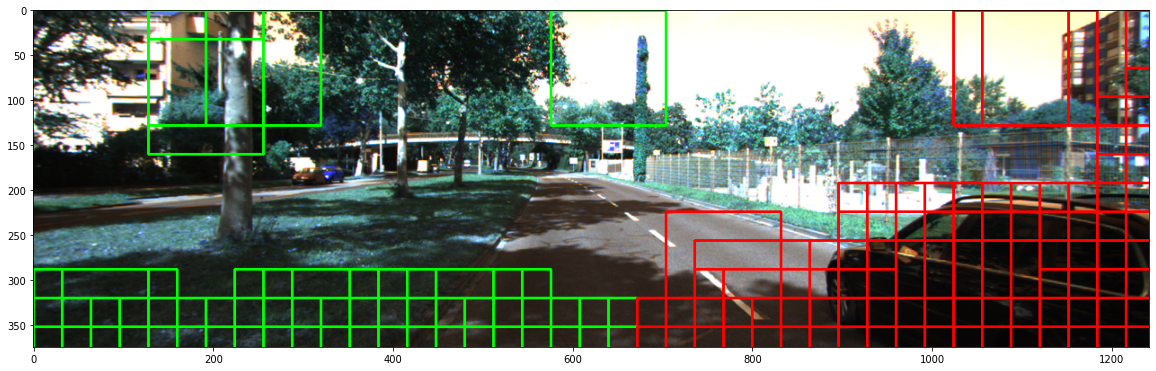

In [ ]:
def groupByLable(A,B):#A is the box, B is the lable
  result = {}
  for i in range(B.shape[0]):
    if B[i] in result.keys():
      result[B[i]].append(A[i])
    else:
      result[B[i]] = [A[i]]
  return result
kMeanTestImg = cv.imread(imgPath)
for i in range(len(boxes)):
  if(boxesLables[i] == 0):
    cv.rectangle(kMeanTestImg, (boxes[i][0], boxes[i][1]), (boxes[i][2], boxes[i][3]), (0, 255, 0), 2)
  elif(boxesLables[i] == 1):
    cv.rectangle(kMeanTestImg, (boxes[i][0], boxes[i][1]), (boxes[i][2], boxes[i][3]), (255, 0, 0), 2)
  elif(boxesLables[i] == 2):
    cv.rectangle(kMeanTestImg, (boxes[i][0], boxes[i][1]), (boxes[i][2], boxes[i][3]), (0, 0, 255), 2)
plt.figure(figsize=(20,20))
plt.imshow(kMeanTestImg)
groupBox = groupByLable(boxes,boxesLables)
print(groupBox.keys())

rectange:  [array([128,   0, 256, 128]), array([192,   0, 320, 128]), array([576,   0, 704, 128]), array([128,  32, 256, 160]), array([  0, 288, 128, 416]), array([ 32, 288, 160, 416]), array([224, 288, 352, 416]), array([256, 288, 384, 416]), array([288, 288, 416, 416]), array([384, 288, 512, 416]), array([416, 288, 544, 416]), array([448, 288, 576, 416]), array([  0, 320, 128, 448]), array([ 32, 320, 160, 448]), array([ 64, 320, 192, 448]), array([ 96, 320, 224, 448]), array([128, 320, 256, 448]), array([160, 320, 288, 448]), array([192, 320, 320, 448]), array([224, 320, 352, 448]), array([256, 320, 384, 448]), array([288, 320, 416, 448]), array([320, 320, 448, 448]), array([352, 320, 480, 448]), array([384, 320, 512, 448]), array([416, 320, 544, 448]), array([448, 320, 576, 448]), array([480, 320, 608, 448]), array([512, 320, 640, 448]), array([544, 320, 672, 448]), array([576, 320, 704, 448]), array([608, 320, 736, 448]), array([640, 320, 768, 448]), array([  0, 352, 128, 480]), ar

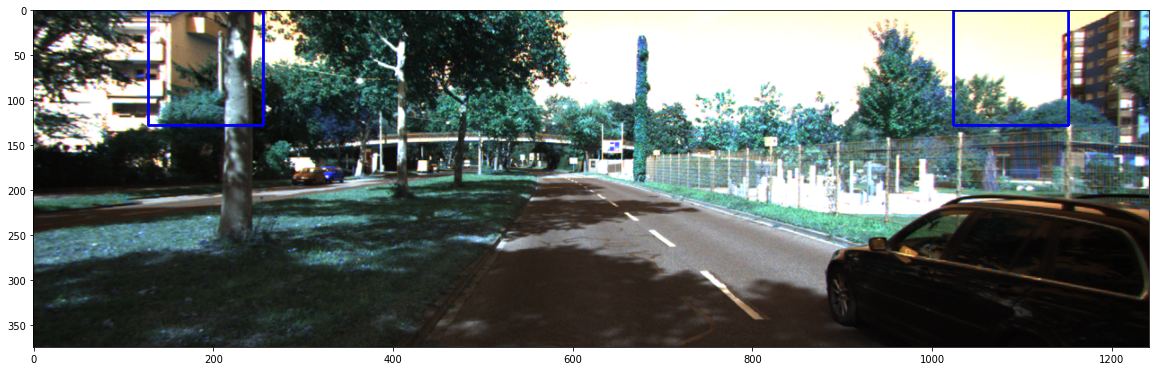

In [ ]:
NMSTestImg = cv.imread(imgPath)
finalBox = []
for theKey in groupBox.keys():
  print("rectange: ",groupBox[theKey])
  rectangles = (np.vstack(np.array(groupBox[theKey]).astype(int).flatten()))
  finalBox.append(rectangles)
  #print(finalBox)
#print(finalBox)
for i in range(len(finalBox)):
  cv.rectangle(NMSTestImg, (finalBox[i][0], finalBox[i][1]), (finalBox[i][2], finalBox[i][3]), (0, 0, 255), 2)
plt.figure(figsize=(20,20))
plt.imshow(NMSTestImg)

cross validation classifier test

In [ ]:
#open classifiers models with cross validation
genPath = "/content/drive/My Drive/crossV_svm_models/"
filename = 'Copy of svc_model_0001_0002.sav'
f = open(genPath+filename, 'rb')
clf = pickle.load(f)
f.close

<function BufferedReader.close>

In [ ]:
#load the image
imgPath = "/content/drive/My Drive/dataset/0002/000152.png"
boxes = []
(winW, winH) = (128, 128)
image = cv.imread(imgPath)
for (x, y, window) in sliding_window(image, stepSize=32, windowSize=(winW, winH)):
  if check_svm(window) == "vehicle":
    theBox = [x,y,x + winW,y + winH]
    boxes.append(theBox)
    cv.rectangle(imgFal, (x, y), (x + winW, y + winH), (0, 255, 0), 2)

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(imgFal)

calculate IOU for cross vaildation for 0001_0002

In [ ]:
def parse(filepath):
  '''
      Parse gt.txt with format
        <frame>, <id>, <type>, <truncated>, <occluded>, <alpha>, <bb_left>, <bb_top>, <bb_right>, <bb_bottom>, <3D_H>, <3D_W>, <3D_L>, <x>, <y>, <z>, <ry>
      Return dict as:
        <type> = "Car", "Van", "Truck", "Pedastrian", "Person_sitting", "Cyclist", "Tram", "Misc", "DontCare"
        key: frame
        value: list - <id>, <bb_left>, <bb_top>, <bb_right>, <bb_bottom>
      Feel free to edit your structure as needed!
  '''

  used_type = ["Car", "Van", "Truck", "Tram"]

  lines = open(filepath, "r").readlines()                                 
  bbox = {}
       #  <frame>, <id>, <truncated>, <occluded>, <alpha>, <bb_left>, <bb_top>, <bb_right>, <bb_bottom>, <3D_H>, <3D_W>, <3D_L>, <x>,   <y>,   <z>,   <ry>
  mask = [False,   True,  False,       False,      False,   True,      True,     True,       True,        False,  False,  False,  False, False, False, False]
  
  for line in lines:
    l = line.strip().split(' ') #convert line to list
    typ = l.pop(2)  # get type of bbox 
    line = np.asarray(l).astype(np.float32) # convert into array 
    frame, line = int(line[0]), line[mask] # get frame number and mask the line   
    if frame not in bbox.keys():
      bbox[frame] = []   
    if typ in used_type:
        bbox[frame].append(line)
  return bbox

def findAllBoxesInOneImg(imgPath):
  boxes = []
  (winW, winH) = (128, 128)
  image = cv.imread(imgPath)
  for (x, y, window) in sliding_window(image, stepSize=32, windowSize=(winW, winH)):
    if check_svm(window) == "vehicle":
      theBox = [x,y,x + winW,y + winH]
      boxes.append(theBox)
  return boxes

def hasOverlap(x1,y1,px1,py1,x2,y2,px2,py2):
  if (x1 == px1 and y1 == py1 and x2 == px2 and y2 == py2):
    return False;
  if (x1 >= px2 and x2 >= px1):
    return False;
  if (py1 >= y2 and py2 >= y1):
    return False;
  return True;
  
def findIoU(bbox):
  counter = 0
  IoUs = []
  for i in range(int(len(bbox.keys())/2)):
    keys  = list(bbox.keys())[i]
    numImg = str(keys).zfill(6)+".png"
    imgPath = "/content/drive/My Drive/dataset/0000/"+numImg
    allbox = findAllBoxesInOneImg(imgPath)
    allboxlen = len(allbox)
    counter = [0 for _ in range(len(bbox[keys]))]#keep track on the false negitive and true positve
    for i in range(len(bbox[keys])):
      for boxTwo in allbox:
        boxOne = bbox[keys][i]
        if hasOverlap(boxTwo[0],boxTwo[1],boxTwo[2],boxTwo[3],boxOne[1],boxOne[2],boxOne[3],boxOne[4]):
          counter[i] = counter[i]+1
          allbox.remove(boxTwo)
    truePosi = sum(counter)
    falsePosi = allboxlen - truePosi
    falseNeg = counter.count(0)
    IoU = truePosi/(falsePosi+truePosi+falseNeg)
    IoUs.append(IoU)
    #print(IoU)

  return sum(IoUs) / len(IoUs)

In [ ]:
# filePath = "/content/drive/My Drive/dataset/0000.txt"
# bbox0000 = parse(filePath)
# ious = (findIoU(bbox0000))
# print("the iou for image in 0000 sets is: ",ious)

calculate IOU for cross vaildation for 0001_0002

In [ ]:
# #open classifiers models with cross validation
# import pickle
# genPath = "/content/drive/My Drive/crossV_svm_models/"
# filename = 'Copy of svc_model_0000_0002.sav'
# f = open(genPath+filename, 'rb')
# clf = pickle.load(f)
# f.close

In [ ]:
# filePath = "/content/drive/My Drive/dataset/0000.txt"
# bbox0000 = parse(filePath)
# ious = (findIoU(bbox0000))
# print("the iou for image in 0000 sets is: ",ious)

calculate IOU for cross vaildation for 0000_0001

In [ ]:
# #open classifiers models with cross validation
# import pickle
# genPath = "/content/drive/My Drive/crossV_svm_models/"
# filename = 'Copy of svc_model_0000_0001.sav'
# f = open(genPath+filename, 'rb')
# clf = pickle.load(f)
# f.close

In [ ]:
# filePath = "/content/drive/My Drive/dataset/0000.txt"
# bbox0000 = parse(filePath)
# ious = (findIoU(bbox0000))
# print("the iou for image in 0000 sets is: ",ious)